# Accelerations and decelerations from Taylor et al. 2000

## Summary

This notebook implements the method for acceleration and deceleration detection from Taylor et al. 2000, based on the MATLAB implemention in the FHRMA package.

[Taylor et al. 2000](https://doi.org/10.1111/j.1471-0528.2000.tb11112.x) - The development and validation of an algorithm for real-time computerised fetal heart rate monitoring in labour

## Paper description of method

**Cleaning signals:** "Both the fetal heart rate and uterine pressure signals contained artefact... Artefact must be removed prior to determining the timing of the decelerations; this is achieved by a low pass fourth order Butterworth filter with a cut off frequency of 0.02 Hz"

**Identifying accelerations and decelerations:** "Accelerations and decelerations were determined and classified according to definitions given by FIGO."

Not performed in FHRMA but also in paper:
* **Classifying decelerations:** "The classification of decelerations was based upon the temporal relationship between the minimum of the deceleration and the maximum of the associated uterine contraction. The uterine contractions were timed by means of an external tocograph. A late deceleration occurred where its minimum value was 20–60 s after the peak of a contraction"
* **Calculating FHR variability:** "The fetal heart rate variability is calculated as twice the standard deviation of the fetal heart rate recorded continuously, after removing the accelerations and decelerations. Reduced variability is defined as one standard deviation < 5 beats per minute."

As you can see, the description of the method for identifying accelerations and decelerations is not clear, and I have followed the interpretation of Boudet et al. in their MATLAB code.

## MATLAB Implementation

FHRMA includes results from using the simple acceleration/deceleration algorithm, as well as results from their interpretation of Taylor et al. 2000. The Taylor version uses `aamtaylor.m`, `butterfilt.m`, `startendlist.m`, and `validaccident.m`.

## Set-up

Import required packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, sosfiltfilt
import sys

Import functions defined elsewhere

In [2]:
sys.path.append('/functions')
from functions.load_data import load_data
from functions.simple_acc_dec_detection import create_accident_df
from functions.simple_acc_dec_validation import validation_against_fhrma

## Python implementation of the paper's method

Import datasets required for running the function and validation

In [3]:
raw_fhr, fhrma_base, fhrma_acc, fhrma_dec = load_data(fhrma_path = './data/T_orig.mat')

Result from FHRMA

In [4]:
fhrma_acc['train28']

array([], shape=(0, 2), dtype=uint8)

**Step-by-step implementation in Python**

Apply Butterworth filter to the FHR data.

In [5]:
fhr = raw_fhr['train28']
baseline = fhrma_base['train28']

# Generate butterworth filter
sos = butter(
    N=4, # Filter's order
    Wn=0.002, # Critical frequency
    btype='low', # Kind of filter
    fs = 4, # Sampling frequency
    output='sos' # Output type
)

# Use filtfilt() (instead of sosfilt) as it applies the filter
# twice, forwards and backwards, so you get zero-phase filtering
fuzzy_line = sosfiltfilt(sos, fhr)

Compared to MATLAB, the fuzzy line is very flat, so not anticipating will match up with FHRMA. In order to be more consistent, would need to produce a butterworth filter manually that matches theirs.

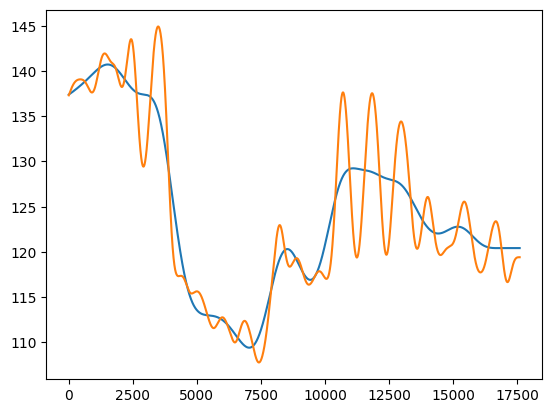

In [6]:
# Show what this has done
plt.plot(fuzzy_line)
plt.plot(baseline)

Create list of periods where there is a 10bpm difference - between baseline and the fuzzyline - these are the acceleration candidates.

In [7]:
binsig = (fuzzy_line-baseline > 10)
pd.Series(binsig).value_counts()

False    17595
Name: count, dtype: int64

Not continued as not going to match up without matching butterworth.

## Python implementation of the simple acc/dec detection method

Import datasets required for running the function and validation

In [8]:
raw_fhr, fhrma_base, fhrma_acc, fhrma_dec = load_data(fhrma_path = './data/T_std.mat')

Accelerations

,record,fhrma,python,match
0,train28,"[[61.8625, 62.31666666666667]]","[[61.8625, 62.31666666666667]]",True
1,test80,"[[21.7875, 22.241666666666667], [25.7791666666...","[[21.7875, 22.241666666666667], [25.7791666666...",True
2,test68,"[[8.545833333333333, 8.9625], [9.125, 9.4875],...","[[8.545833333333333, 8.9625], [9.125, 9.4875],...",True
3,train04,"[[0.05, 0.31666666666666665], [25.65, 26.30416...","[[0.05, 0.31666666666666665], [25.65, 26.30416...",True
4,train31,"[[16.9125, 17.979166666666668], [19.2, 19.5916...","[[16.9125, 17.979166666666668], [19.2, 19.5916...",True


count_diff
0    156
Name: count, dtype: int64


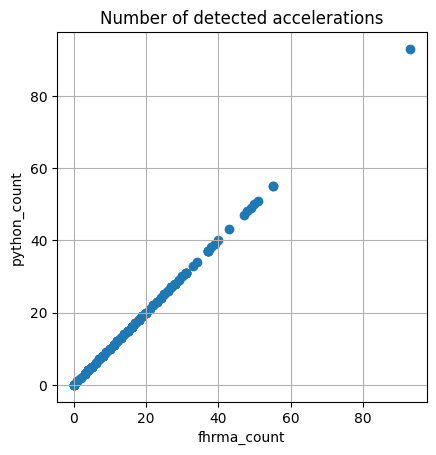

total_diff
0.0    156
Name: count, dtype: int64


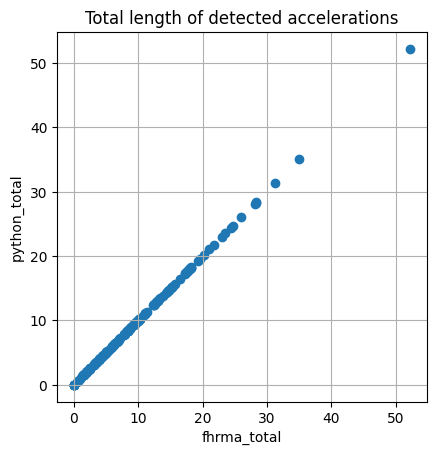

In [9]:
acc_result = create_accident_df(
    raw_fhr=raw_fhr,
    fhrma_base=fhrma_base,
    fhrma_dict=fhrma_acc,
    type='acc')
display(acc_result.head())

validation_against_fhrma(acc_result, 'accelerations')

Decelerations

,record,fhrma,python,match
0,train28,"[[9.2625, 9.941666666666666], [46.0, 46.254166...","[[9.2625, 9.941666666666666], [46.0, 46.254166...",True
1,test80,"[[67.40416666666667, 67.69583333333334], [68.3...","[[67.40416666666667, 67.69583333333334], [68.3...",True
2,test68,"[[26.033333333333335, 26.625], [34.15416666666...","[[26.033333333333335, 26.625], [34.15416666666...",True
3,train04,"[[3.9125, 4.179166666666666], [23.3875, 24.141...","[[3.9125, 4.179166666666666], [23.3875, 24.141...",True
4,train31,"[[0.15, 0.6291666666666667], [3.7625, 4.379166...","[[0.15, 0.6291666666666667], [3.7625, 4.379166...",True


count_diff
0    156
Name: count, dtype: int64


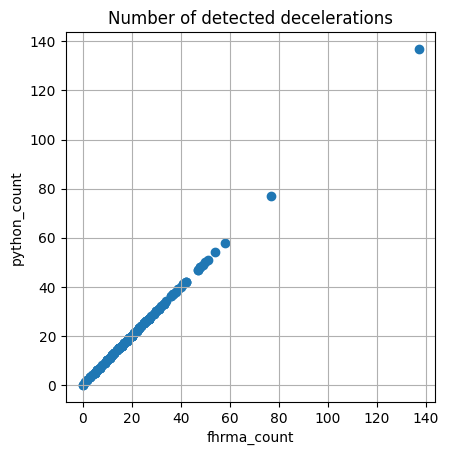

total_diff
0.0    156
Name: count, dtype: int64


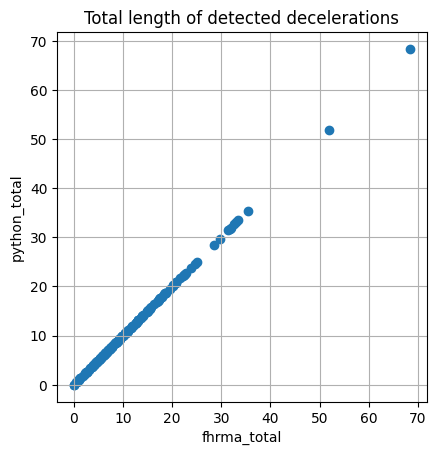

In [10]:
dec_result = create_accident_df(
    raw_fhr=raw_fhr,
    fhrma_base=fhrma_base,
    fhrma_dict=fhrma_dec,
    type='dec')
display(dec_result.head())

validation_against_fhrma(dec_result, 'decelerations')